Pytorch example for VAE: [link](https://github.com/pytorch/examples/blob/main/vae/main.py)



In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

c:\Users\Vimarsh\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9912422/9912422 [00:03<00:00, 2626503.63it/s]


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2306907.14it/s]


Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2134561.39it/s]


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



In [105]:
def gaussian_like(mean, variance, std):
        # Create a Gaussian distribution with the given mean and variance
        distribution = torch.distributions.Normal(mean, variance.sqrt())
        
        # Sample from the distribution and scale by the standard deviation
        sample = distribution.sample()
        output = sample * std
        
        return output

def beta_distribution_like(alpha, beta, std):
    # Create a Beta distribution with the given alpha and beta
    distribution = torch.distributions.Beta(alpha, beta)
    
    # Sample from the distribution and scale by the standard deviation
    sample = distribution.sample()
    output = sample * std
    
    return output

def gamma_distribution_like(alpha, beta, std):
    # Create a Gamma distribution with the given alpha and beta
    distribution = torch.distributions.Gamma(alpha, beta)
    
    # Sample from the distribution and scale by the standard deviation
    sample = distribution.sample()
    output = sample * std
    
    return output

In [109]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling_normal(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) #
        return eps.mul(std).add_(mu) # return z sample
    
    
    
    def sampling_gaussian(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = gaussian_like(torch.tensor(1.0),torch.tensor(2.0), std) #
        return eps.mul(std).add_(mu) # return z sample
    
    def sampling_beta(self, alpha, beta):
        return beta_distribution_like(alpha, beta, 1.0)
    
    def sampling_gamma(self, alpha, beta):
        return gamma_distribution_like(alpha, beta, 1.0)

    
    # IGNORE BELOW
    # standard normal
    def sampling_standard_normal(self, mu, log_var):
        # std = torch.exp(0.5*log_var)
        # eps = torch.distributions.Normal(0,1)
        # return torch.distributions.Normal(mu, log_var).sample().mul(torch.exp(0.5*log_var)).add_(mu)
        return torch.distributions.Normal(mu, log_var).sample()

    # mean = 1, std = 2
    def gaussian_sampling(self, mu, log_var):
        return torch.distributions.Normal(1, 2).sample()
    
    # beta distribution
    def beta_sampling(self, alpha, beta):
        alpha = torch.ones_like(alpha) * 2  # set alpha to 2
        beta = torch.ones_like(beta) * 2  # set beta to 2
        return torch.distributions.beta.Beta(alpha, beta).sample()
    
    # gamma 3,2 distribution
    def gamma_sampling(self, alpha, beta):
        alpha = torch.ones_like(alpha) * 3  # set alpha to 3
        beta = torch.ones_like(beta) * 2  # set beta to 2
        return torch.distributions.gamma.Gamma(alpha, beta).sample()
                
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling2(mu, log_var)
        # z = self.sampling_standard_normal(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [99]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [100]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [101]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if(torch.cuda.is_available()):
            data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [102]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if(torch.cuda.is_available()):
                data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [69]:
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.106484
Train Epoch: 1 [10000/60000 (17%)]	Loss: 544.151797
Train Epoch: 1 [20000/60000 (33%)]	Loss: 544.221953
Train Epoch: 1 [30000/60000 (50%)]	Loss: 544.170547
Train Epoch: 1 [40000/60000 (67%)]	Loss: 544.137734
Train Epoch: 1 [50000/60000 (83%)]	Loss: 544.048477
====> Epoch: 1 Average loss: 544.1036
====> Test set loss: 544.1630
Train Epoch: 2 [0/60000 (0%)]	Loss: 544.541953
Train Epoch: 2 [10000/60000 (17%)]	Loss: 544.251875
Train Epoch: 2 [20000/60000 (33%)]	Loss: 544.103945
Train Epoch: 2 [30000/60000 (50%)]	Loss: 544.083555
Train Epoch: 2 [40000/60000 (67%)]	Loss: 543.874766
Train Epoch: 2 [50000/60000 (83%)]	Loss: 544.113359
====> Epoch: 2 Average loss: 544.1015
====> Test set loss: 544.1673
Train Epoch: 3 [0/60000 (0%)]	Loss: 544.360312
Train Epoch: 3 [10000/60000 (17%)]	Loss: 544.038281
Train Epoch: 3 [20000/60000 (33%)]	Loss: 543.990977
Train Epoch: 3 [30000/60000 (50%)]	Loss: 543.887187
Train Epoch: 3 [40000/60000 (67%)]	Loss: 544.06

In [70]:
# with torch.no_grad():
#     z = torch.randn(64, 2).cuda()
#     sample = vae.decoder(z).cuda()
    
#     save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

with torch.no_grad():
    z = torch.randn(64, 2) 
    # print(z)
    sample = vae.decoder(z)
    
    sample2 = vae.decoder(torch.Tensor([0, -0.5]))
    
    save_image(sample.view(64, 1, 28, 28), './sample_v1_' + '.png')
    save_image(sample2.view(1, 1, 28, 28), './sample_v1_2_' + '.png')




In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_space = vae.encoder(data2)

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2)
latent_space_2d = tsne.fit_transform(latent_space)

# Plot the 2D latent space
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1])
plt.show()

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the VAE model
class VAE2(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Define training parameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 1000

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
# vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [128]:
# Training loop
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 1/1000: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]


Epoch 1/1000, Loss: 189.61143064778645


Epoch 2/1000: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]


Epoch 2/1000, Loss: 159.5851456217448


Epoch 3/1000: 100%|██████████| 469/469 [00:34<00:00, 13.56it/s]


Epoch 3/1000, Loss: 152.34722583007812


Epoch 4/1000: 100%|██████████| 469/469 [00:30<00:00, 15.52it/s]


Epoch 4/1000, Loss: 148.9296219563802


Epoch 5/1000: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]


Epoch 5/1000, Loss: 146.79649624023438


Epoch 6/1000: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


Epoch 6/1000, Loss: 144.9844571451823


Epoch 7/1000: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]


Epoch 7/1000, Loss: 143.81496544596354


Epoch 8/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 8/1000, Loss: 142.7002927734375


Epoch 9/1000: 100%|██████████| 469/469 [00:30<00:00, 15.42it/s]


Epoch 9/1000, Loss: 141.70092630208333


Epoch 10/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 10/1000, Loss: 140.8713334798177


Epoch 11/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 11/1000, Loss: 140.10187548828125


Epoch 12/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]


Epoch 12/1000, Loss: 139.42701821289063


Epoch 13/1000: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 13/1000, Loss: 138.85285978190103


Epoch 14/1000: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]


Epoch 14/1000, Loss: 138.40629064127603


Epoch 15/1000: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 15/1000, Loss: 137.94847019856772


Epoch 16/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 16/1000, Loss: 137.67789744466145


Epoch 17/1000: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]


Epoch 17/1000, Loss: 137.09279775390624


Epoch 18/1000: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]


Epoch 18/1000, Loss: 136.6216714355469


Epoch 19/1000: 100%|██████████| 469/469 [00:29<00:00, 15.73it/s]


Epoch 19/1000, Loss: 136.46075569661457


Epoch 20/1000: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s]


Epoch 20/1000, Loss: 136.05165904947916


Epoch 21/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 21/1000, Loss: 135.85922869466145


Epoch 22/1000: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]


Epoch 22/1000, Loss: 135.7191385579427


Epoch 23/1000: 100%|██████████| 469/469 [00:19<00:00, 23.68it/s]


Epoch 23/1000, Loss: 135.29261083984375


Epoch 24/1000: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch 24/1000, Loss: 135.0834155110677


Epoch 25/1000: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]


Epoch 25/1000, Loss: 134.7565514485677


Epoch 26/1000: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Epoch 26/1000, Loss: 134.70506884765626


Epoch 27/1000: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]


Epoch 27/1000, Loss: 134.3578471516927


Epoch 28/1000: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]


Epoch 28/1000, Loss: 134.44119702148438


Epoch 29/1000: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]


Epoch 29/1000, Loss: 134.378312890625


Epoch 30/1000: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]


Epoch 30/1000, Loss: 134.03274549153645


Epoch 31/1000: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]


Epoch 31/1000, Loss: 133.90738714192707


Epoch 32/1000: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]


Epoch 32/1000, Loss: 133.92185747070312


Epoch 33/1000: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]


Epoch 33/1000, Loss: 133.65683017578124


Epoch 34/1000: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]


Epoch 34/1000, Loss: 133.44677223307292


Epoch 35/1000: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]


Epoch 35/1000, Loss: 133.36638139648437


Epoch 36/1000: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 36/1000, Loss: 133.1804624674479


Epoch 37/1000: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Epoch 37/1000, Loss: 133.0093848795573


Epoch 38/1000: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Epoch 38/1000, Loss: 132.8167991373698


Epoch 39/1000: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]


Epoch 39/1000, Loss: 133.00653017578125


Epoch 40/1000: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]


Epoch 40/1000, Loss: 132.47696725260417


Epoch 41/1000: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Epoch 41/1000, Loss: 132.61626396484374


Epoch 42/1000: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]


Epoch 42/1000, Loss: 132.57392692057292


Epoch 43/1000: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]


Epoch 43/1000, Loss: 132.56875685221354


Epoch 44/1000: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]


Epoch 44/1000, Loss: 132.1789916829427


Epoch 45/1000: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]


Epoch 45/1000, Loss: 132.34040607096355


Epoch 46/1000: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]


Epoch 46/1000, Loss: 132.14224225260418


Epoch 47/1000: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]


Epoch 47/1000, Loss: 132.19776704101562


Epoch 48/1000: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]


Epoch 48/1000, Loss: 132.32325454101561


Epoch 49/1000: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Epoch 49/1000, Loss: 131.9543440592448


Epoch 50/1000: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]


Epoch 50/1000, Loss: 132.03841233723958


Epoch 51/1000: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]


Epoch 51/1000, Loss: 131.74642555338542


Epoch 52/1000: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 52/1000, Loss: 131.9483788574219


Epoch 53/1000: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]


Epoch 53/1000, Loss: 131.6125210123698


Epoch 54/1000: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]


Epoch 54/1000, Loss: 131.68536303710937


Epoch 55/1000: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]


Epoch 55/1000, Loss: 131.29679588216146


Epoch 56/1000: 100%|██████████| 469/469 [00:19<00:00, 23.86it/s]


Epoch 56/1000, Loss: 131.36370528971355


Epoch 57/1000: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]


Epoch 57/1000, Loss: 131.17262135416667


Epoch 58/1000: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]


Epoch 58/1000, Loss: 131.1176114095052


Epoch 59/1000: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]


Epoch 59/1000, Loss: 131.08602262369791


Epoch 60/1000: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]


Epoch 60/1000, Loss: 130.95481850585938


Epoch 61/1000: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]


Epoch 61/1000, Loss: 130.99273823242189


Epoch 62/1000: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]


Epoch 62/1000, Loss: 131.33103732096353


Epoch 63/1000: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]


Epoch 63/1000, Loss: 130.88743391927082


Epoch 64/1000: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


Epoch 64/1000, Loss: 130.9447177734375


Epoch 65/1000: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]


Epoch 65/1000, Loss: 130.94858841145833


Epoch 66/1000: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Epoch 66/1000, Loss: 130.83520265299478


Epoch 67/1000: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]


Epoch 67/1000, Loss: 130.71131752929688


Epoch 68/1000: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Epoch 68/1000, Loss: 130.56029282226564


Epoch 69/1000: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Epoch 69/1000, Loss: 130.37068103841145


Epoch 70/1000: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Epoch 70/1000, Loss: 130.27190423177083


Epoch 71/1000: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]


Epoch 71/1000, Loss: 130.1728596842448


Epoch 72/1000: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]


Epoch 72/1000, Loss: 130.244795703125


Epoch 73/1000: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]


Epoch 73/1000, Loss: 130.5372399251302


Epoch 74/1000: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]


Epoch 74/1000, Loss: 130.7582039876302


Epoch 75/1000: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]


Epoch 75/1000, Loss: 130.21149371744792


Epoch 76/1000: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Epoch 76/1000, Loss: 130.02310639648437


Epoch 77/1000: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]


Epoch 77/1000, Loss: 129.83800131835937


Epoch 78/1000: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Epoch 78/1000, Loss: 129.92057141927083


Epoch 79/1000: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 79/1000, Loss: 130.30082236328124


Epoch 80/1000: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 80/1000, Loss: 130.10118489583334


Epoch 81/1000: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Epoch 81/1000, Loss: 130.27302307942708


Epoch 82/1000: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]


Epoch 82/1000, Loss: 130.14153434244793


Epoch 83/1000: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 83/1000, Loss: 130.12876814778645


Epoch 84/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 84/1000, Loss: 130.40972513020833


Epoch 85/1000: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]


Epoch 85/1000, Loss: 130.39547299804687


Epoch 86/1000: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]


Epoch 86/1000, Loss: 129.98635611979168


Epoch 87/1000: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]


Epoch 87/1000, Loss: 129.85550805664062


Epoch 88/1000: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Epoch 88/1000, Loss: 129.90077799479167


Epoch 89/1000: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]


Epoch 89/1000, Loss: 129.8181909016927


Epoch 90/1000: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Epoch 90/1000, Loss: 129.7298544433594


Epoch 91/1000: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]


Epoch 91/1000, Loss: 129.81881806640624


Epoch 92/1000: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Epoch 92/1000, Loss: 129.70335906575522


Epoch 93/1000: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Epoch 93/1000, Loss: 129.2938356282552


Epoch 94/1000: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Epoch 94/1000, Loss: 129.3095640625


Epoch 95/1000: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]


Epoch 95/1000, Loss: 129.5383737955729


Epoch 96/1000: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Epoch 96/1000, Loss: 129.60131806640624


Epoch 97/1000: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]


Epoch 97/1000, Loss: 129.3460157714844


Epoch 98/1000: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]


Epoch 98/1000, Loss: 129.89456813151043


Epoch 99/1000: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]


Epoch 99/1000, Loss: 130.02918356119793


Epoch 100/1000: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]


Epoch 100/1000, Loss: 129.54965113932292


Epoch 101/1000: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


Epoch 101/1000, Loss: 129.80075187174478


Epoch 102/1000: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]


Epoch 102/1000, Loss: 129.36347924804687


Epoch 103/1000: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Epoch 103/1000, Loss: 129.19280485026042


Epoch 104/1000: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]


Epoch 104/1000, Loss: 129.43127177734374


Epoch 105/1000: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 105/1000, Loss: 129.30627241210937


Epoch 106/1000: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Epoch 106/1000, Loss: 129.8056505859375


Epoch 107/1000: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]


Epoch 107/1000, Loss: 129.37239970703126


Epoch 108/1000: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]


Epoch 108/1000, Loss: 129.19587216796876


Epoch 109/1000: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]


Epoch 109/1000, Loss: 128.95130271809896


Epoch 110/1000: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]


Epoch 110/1000, Loss: 129.0529345703125


Epoch 111/1000: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 111/1000, Loss: 129.31093619791667


Epoch 112/1000: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]


Epoch 112/1000, Loss: 129.3520924967448


Epoch 113/1000: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


Epoch 113/1000, Loss: 128.98323785807293


Epoch 114/1000: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


Epoch 114/1000, Loss: 129.02579321289062


Epoch 115/1000: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]


Epoch 115/1000, Loss: 129.17196155598958


Epoch 116/1000: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]


Epoch 116/1000, Loss: 129.26078764648437


Epoch 117/1000: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]


Epoch 117/1000, Loss: 128.83355900065104


Epoch 118/1000: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]


Epoch 118/1000, Loss: 129.04337459309895


Epoch 119/1000: 100%|██████████| 469/469 [00:23<00:00, 20.05it/s]


Epoch 119/1000, Loss: 128.97428424479168


Epoch 120/1000: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


Epoch 120/1000, Loss: 128.97835338541665


Epoch 121/1000: 100%|██████████| 469/469 [00:24<00:00, 18.84it/s]


Epoch 121/1000, Loss: 128.52635727539064


Epoch 122/1000: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]


Epoch 122/1000, Loss: 128.4371107910156


Epoch 123/1000: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]


Epoch 123/1000, Loss: 128.49962501627604


Epoch 124/1000: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]


Epoch 124/1000, Loss: 128.61937403971353


Epoch 125/1000: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]


Epoch 125/1000, Loss: 128.41503681640626


Epoch 126/1000: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]


Epoch 126/1000, Loss: 128.11965004882813


Epoch 127/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 127/1000, Loss: 128.29602620442708


Epoch 128/1000: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]


Epoch 128/1000, Loss: 128.40850668945313


Epoch 129/1000: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]


Epoch 129/1000, Loss: 128.43147327473957


Epoch 130/1000: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 130/1000, Loss: 128.44542141927084


Epoch 131/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 131/1000, Loss: 128.57661806640624


Epoch 132/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 132/1000, Loss: 128.32751368815104


Epoch 133/1000: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]


Epoch 133/1000, Loss: 129.51671101888022


Epoch 134/1000: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]


Epoch 134/1000, Loss: 129.22173185221354


Epoch 135/1000: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]


Epoch 135/1000, Loss: 128.73728154296876


Epoch 136/1000: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Epoch 136/1000, Loss: 128.76085568033855


Epoch 137/1000: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]


Epoch 137/1000, Loss: 128.54156225585936


Epoch 138/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 138/1000, Loss: 128.11650618489583


Epoch 139/1000: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]


Epoch 139/1000, Loss: 128.30358675130208


Epoch 140/1000: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Epoch 140/1000, Loss: 128.59671596679686


Epoch 141/1000: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]


Epoch 141/1000, Loss: 128.02897736002603


Epoch 142/1000: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch 142/1000, Loss: 128.4254947265625


Epoch 143/1000: 100%|██████████| 469/469 [00:24<00:00, 18.76it/s]


Epoch 143/1000, Loss: 128.25843837890625


Epoch 144/1000: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]


Epoch 144/1000, Loss: 127.97060564778646


Epoch 145/1000: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Epoch 145/1000, Loss: 128.05270903320312


Epoch 146/1000: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]


Epoch 146/1000, Loss: 127.94664788411458


Epoch 147/1000: 100%|██████████| 469/469 [00:24<00:00, 19.34it/s]


Epoch 147/1000, Loss: 127.96357431640625


Epoch 148/1000: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]


Epoch 148/1000, Loss: 128.0153784830729


Epoch 149/1000: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Epoch 149/1000, Loss: 128.10842086588542


Epoch 150/1000: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]


Epoch 150/1000, Loss: 127.77338149414062


Epoch 151/1000: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]


Epoch 151/1000, Loss: 127.60099072265625


Epoch 152/1000: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]


Epoch 152/1000, Loss: 127.74384002278646


Epoch 153/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 153/1000, Loss: 127.85790151367188


Epoch 154/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 154/1000, Loss: 127.68103909505209


Epoch 155/1000: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 155/1000, Loss: 127.59769763997396


Epoch 156/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 156/1000, Loss: 127.94048040364584


Epoch 157/1000: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]


Epoch 157/1000, Loss: 127.9544787109375


Epoch 158/1000: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]


Epoch 158/1000, Loss: 127.64994444986979


Epoch 159/1000: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Epoch 159/1000, Loss: 127.74079337565104


Epoch 160/1000: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch 160/1000, Loss: 127.3715859375


Epoch 161/1000: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Epoch 161/1000, Loss: 127.43098966471354


Epoch 162/1000: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]


Epoch 162/1000, Loss: 127.67247177734374


Epoch 163/1000: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]


Epoch 163/1000, Loss: 128.05294563802084


Epoch 164/1000: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 164/1000, Loss: 128.26569340820313


Epoch 165/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 165/1000, Loss: 127.91772758789062


Epoch 166/1000: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]


Epoch 166/1000, Loss: 127.7961513671875


Epoch 167/1000: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 167/1000, Loss: 128.04587862955728


Epoch 168/1000: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Epoch 168/1000, Loss: 128.44599220377603


Epoch 169/1000: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


Epoch 169/1000, Loss: 127.88761022135417


Epoch 170/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 170/1000, Loss: 127.77762985026041


Epoch 171/1000: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Epoch 171/1000, Loss: 127.56791290690104


Epoch 172/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 172/1000, Loss: 127.66948295898437


Epoch 173/1000: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


Epoch 173/1000, Loss: 127.63404213867187


Epoch 174/1000: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Epoch 174/1000, Loss: 127.49643823242188


Epoch 175/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 175/1000, Loss: 127.76655278320312


Epoch 176/1000: 100%|██████████| 469/469 [00:27<00:00, 17.05it/s]


Epoch 176/1000, Loss: 127.3712571126302


Epoch 177/1000: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]


Epoch 177/1000, Loss: 127.15455903320313


Epoch 178/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 178/1000, Loss: 127.30043077799479


Epoch 179/1000: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]


Epoch 179/1000, Loss: 127.56334069010417


Epoch 180/1000: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]


Epoch 180/1000, Loss: 128.1165213704427


Epoch 181/1000: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s]


Epoch 181/1000, Loss: 127.54514926757813


Epoch 182/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 182/1000, Loss: 127.57403102213542


Epoch 183/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 183/1000, Loss: 127.63436741536458


Epoch 184/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 184/1000, Loss: 127.47700232747395


Epoch 185/1000: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]


Epoch 185/1000, Loss: 127.08624342447916


Epoch 186/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 186/1000, Loss: 127.00632708333333


Epoch 187/1000: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]


Epoch 187/1000, Loss: 127.0541107421875


Epoch 188/1000: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Epoch 188/1000, Loss: 127.24195615234375


Epoch 189/1000: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]


Epoch 189/1000, Loss: 127.0528409342448


Epoch 190/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 190/1000, Loss: 126.9984370279948


Epoch 191/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 191/1000, Loss: 126.77844321289062


Epoch 192/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 192/1000, Loss: 126.8467236328125


Epoch 193/1000: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]


Epoch 193/1000, Loss: 126.72187843424479


Epoch 194/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 194/1000, Loss: 126.8622212890625


Epoch 195/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 195/1000, Loss: 127.07679552408854


Epoch 196/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 196/1000, Loss: 127.20202469075521


Epoch 197/1000: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


Epoch 197/1000, Loss: 126.83182216796875


Epoch 198/1000: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Epoch 198/1000, Loss: 126.60086518554688


Epoch 199/1000: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]


Epoch 199/1000, Loss: 126.69865120442708


Epoch 200/1000: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]


Epoch 200/1000, Loss: 126.95778225911458


Epoch 201/1000: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


Epoch 201/1000, Loss: 127.1244529296875


Epoch 202/1000: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 202/1000, Loss: 127.02752091471355


Epoch 203/1000: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Epoch 203/1000, Loss: 126.81475958658854


Epoch 204/1000: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 204/1000, Loss: 126.5378296875


Epoch 205/1000: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]


Epoch 205/1000, Loss: 126.66049767252605


Epoch 206/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 206/1000, Loss: 126.82109358723959


Epoch 207/1000: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Epoch 207/1000, Loss: 126.90249033203125


Epoch 208/1000: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch 208/1000, Loss: 126.66591271158855


Epoch 209/1000: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s]


Epoch 209/1000, Loss: 126.42834907226562


Epoch 210/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 210/1000, Loss: 126.78706422526042


Epoch 211/1000: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Epoch 211/1000, Loss: 126.84125532226562


Epoch 212/1000: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]


Epoch 212/1000, Loss: 126.95242690429687


Epoch 213/1000: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]


Epoch 213/1000, Loss: 126.64374192708334


Epoch 214/1000: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]


Epoch 214/1000, Loss: 126.52804710286458


Epoch 215/1000: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 215/1000, Loss: 126.55106162109375


Epoch 216/1000: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]


Epoch 216/1000, Loss: 126.3998544108073


Epoch 217/1000: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s]


Epoch 217/1000, Loss: 126.79360045572916


Epoch 218/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 218/1000, Loss: 126.78412102864583


Epoch 219/1000: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]


Epoch 219/1000, Loss: 127.22917493489584


Epoch 220/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]


Epoch 220/1000, Loss: 126.81840169270833


Epoch 221/1000: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]


Epoch 221/1000, Loss: 126.17408987630208


Epoch 222/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 222/1000, Loss: 126.83701552734375


Epoch 223/1000: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Epoch 223/1000, Loss: 126.34107337239584


Epoch 224/1000: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Epoch 224/1000, Loss: 126.31855639648437


Epoch 225/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]


Epoch 225/1000, Loss: 126.09264300130208


Epoch 226/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s]


Epoch 226/1000, Loss: 125.99722084960938


Epoch 227/1000: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


Epoch 227/1000, Loss: 126.03911038411458


Epoch 228/1000: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch 228/1000, Loss: 126.34194228515625


Epoch 229/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


Epoch 229/1000, Loss: 126.30797731119792


Epoch 230/1000: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]


Epoch 230/1000, Loss: 126.02704790039063


Epoch 231/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


Epoch 231/1000, Loss: 126.12991411132812


Epoch 232/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 232/1000, Loss: 126.05431638997396


Epoch 233/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 233/1000, Loss: 126.37315864257812


Epoch 234/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s]


Epoch 234/1000, Loss: 126.58940626627604


Epoch 235/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 235/1000, Loss: 126.25622267252604


Epoch 236/1000: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]


Epoch 236/1000, Loss: 125.94527407226562


Epoch 237/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 237/1000, Loss: 126.49478071289063


Epoch 238/1000: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]


Epoch 238/1000, Loss: 126.1119087890625


Epoch 239/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s]


Epoch 239/1000, Loss: 126.22413500976562


Epoch 240/1000: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Epoch 240/1000, Loss: 126.13111754557292


Epoch 241/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]


Epoch 241/1000, Loss: 126.0549248046875


Epoch 242/1000: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s]


Epoch 242/1000, Loss: 125.88255216471354


Epoch 243/1000: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]


Epoch 243/1000, Loss: 125.77924332682292


Epoch 244/1000: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Epoch 244/1000, Loss: 126.37557464192709


Epoch 245/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 245/1000, Loss: 126.16362154947916


Epoch 246/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 246/1000, Loss: 125.91464921875


Epoch 247/1000: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]


Epoch 247/1000, Loss: 125.82530540364583


Epoch 248/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]


Epoch 248/1000, Loss: 125.59736941731771


Epoch 249/1000: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]


Epoch 249/1000, Loss: 125.93006474609375


Epoch 250/1000: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 250/1000, Loss: 125.59945081380208


Epoch 251/1000: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 251/1000, Loss: 125.58220431315104


Epoch 252/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 252/1000, Loss: 125.80911383463541


Epoch 253/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 253/1000, Loss: 126.0270200358073


Epoch 254/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 254/1000, Loss: 126.10948694661458


Epoch 255/1000: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]


Epoch 255/1000, Loss: 125.793


Epoch 256/1000: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 256/1000, Loss: 125.87060639648438


Epoch 257/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 257/1000, Loss: 125.80494705403646


Epoch 258/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 258/1000, Loss: 125.56157561848958


Epoch 259/1000: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]


Epoch 259/1000, Loss: 125.70277083333333


Epoch 260/1000: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 260/1000, Loss: 125.70703828125


Epoch 261/1000: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]


Epoch 261/1000, Loss: 125.7584126139323


Epoch 262/1000: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Epoch 262/1000, Loss: 126.11516194661458


Epoch 263/1000: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]


Epoch 263/1000, Loss: 126.21024025065104


Epoch 264/1000: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Epoch 264/1000, Loss: 126.77909672851563


Epoch 265/1000: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Epoch 265/1000, Loss: 126.33753203125


Epoch 266/1000: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]


Epoch 266/1000, Loss: 126.1599752766927


Epoch 267/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 267/1000, Loss: 126.38119954427083


Epoch 268/1000: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Epoch 268/1000, Loss: 126.30772446289062


Epoch 269/1000: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Epoch 269/1000, Loss: 125.93456591796875


Epoch 270/1000: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]


Epoch 270/1000, Loss: 126.05306194661458


Epoch 271/1000: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 271/1000, Loss: 125.55703430989584


Epoch 272/1000: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]


Epoch 272/1000, Loss: 125.56087976888021


Epoch 273/1000: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 273/1000, Loss: 125.63032936197916


Epoch 274/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 274/1000, Loss: 125.58813999023438


Epoch 275/1000: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]


Epoch 275/1000, Loss: 125.65569005533854


Epoch 276/1000: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]


Epoch 276/1000, Loss: 126.04722796223959


Epoch 277/1000: 100%|██████████| 469/469 [00:25<00:00, 18.62it/s]


Epoch 277/1000, Loss: 126.10871251627604


Epoch 278/1000: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]


Epoch 278/1000, Loss: 126.04239093424479


Epoch 279/1000: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 279/1000, Loss: 126.01052897135416


Epoch 280/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 280/1000, Loss: 125.59257952473958


Epoch 281/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 281/1000, Loss: 125.6516145670573


Epoch 282/1000: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Epoch 282/1000, Loss: 125.46616469726563


Epoch 283/1000: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 283/1000, Loss: 125.63102115885417


Epoch 284/1000: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]


Epoch 284/1000, Loss: 125.46259407552084


Epoch 285/1000: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]


Epoch 285/1000, Loss: 125.37472467447917


Epoch 286/1000: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]


Epoch 286/1000, Loss: 125.58495078125


Epoch 287/1000: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Epoch 287/1000, Loss: 125.42297532552084


Epoch 288/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 288/1000, Loss: 125.46031209309896


Epoch 289/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]


Epoch 289/1000, Loss: 125.55472561848958


Epoch 290/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 290/1000, Loss: 125.81127340494791


Epoch 291/1000: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s]


Epoch 291/1000, Loss: 125.955826953125


Epoch 292/1000: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch 292/1000, Loss: 126.00561277669271


Epoch 293/1000: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]


Epoch 293/1000, Loss: 125.97164524739583


Epoch 294/1000: 100%|██████████| 469/469 [00:25<00:00, 18.41it/s]


Epoch 294/1000, Loss: 125.76293444010416


Epoch 295/1000: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]


Epoch 295/1000, Loss: 125.62522547200521


Epoch 296/1000: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]


Epoch 296/1000, Loss: 125.65202464192708


Epoch 297/1000: 100%|██████████| 469/469 [00:25<00:00, 18.36it/s]


Epoch 297/1000, Loss: 125.31398963216145


Epoch 298/1000: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


Epoch 298/1000, Loss: 125.44100304361979


Epoch 299/1000: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]


Epoch 299/1000, Loss: 125.82984703776042


Epoch 300/1000: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]


Epoch 300/1000, Loss: 125.85843338216146


Epoch 301/1000: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]


Epoch 301/1000, Loss: 125.558955078125


Epoch 302/1000: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]


Epoch 302/1000, Loss: 126.12143279622396


Epoch 303/1000: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]


Epoch 303/1000, Loss: 125.94387387695312


Epoch 304/1000: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 304/1000, Loss: 125.75852198893229


Epoch 305/1000: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]


Epoch 305/1000, Loss: 125.4499119954427


Epoch 306/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]


Epoch 306/1000, Loss: 125.2694615234375


Epoch 307/1000: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]


Epoch 307/1000, Loss: 125.38044453125


Epoch 308/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 308/1000, Loss: 125.24167386067708


Epoch 309/1000: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]


Epoch 309/1000, Loss: 125.5231243001302


Epoch 310/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 310/1000, Loss: 125.57037254231771


Epoch 311/1000: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Epoch 311/1000, Loss: 125.58088354492187


Epoch 312/1000: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]


Epoch 312/1000, Loss: 125.08044145507813


Epoch 313/1000: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]


Epoch 313/1000, Loss: 125.1171537109375


Epoch 314/1000: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]


Epoch 314/1000, Loss: 125.222857421875


Epoch 315/1000: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]


Epoch 315/1000, Loss: 125.14246702473959


Epoch 316/1000: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 316/1000, Loss: 125.18885402018229


Epoch 317/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]


Epoch 317/1000, Loss: 125.18425159505209


Epoch 318/1000: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]


Epoch 318/1000, Loss: 125.09422132161458


Epoch 319/1000: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch 319/1000, Loss: 124.90896868489584


Epoch 320/1000: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]


Epoch 320/1000, Loss: 124.70770135091146


Epoch 321/1000: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Epoch 321/1000, Loss: 125.53611650390626


Epoch 322/1000: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]


Epoch 322/1000, Loss: 125.15058670247396


Epoch 323/1000: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]


Epoch 323/1000, Loss: 124.99733118489583


Epoch 324/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 324/1000, Loss: 125.06636056315104


Epoch 325/1000: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Epoch 325/1000, Loss: 125.23479926757813


Epoch 326/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 326/1000, Loss: 125.8160993001302


Epoch 327/1000: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 327/1000, Loss: 125.31311272786458


Epoch 328/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 328/1000, Loss: 125.465731640625


Epoch 329/1000: 100%|██████████| 469/469 [00:26<00:00, 17.37it/s]


Epoch 329/1000, Loss: 125.66775660807292


Epoch 330/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 330/1000, Loss: 125.42576998697916


Epoch 331/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 331/1000, Loss: 125.28098059895834


Epoch 332/1000: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]


Epoch 332/1000, Loss: 125.14963562825521


Epoch 333/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 333/1000, Loss: 125.06959251302084


Epoch 334/1000: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]


Epoch 334/1000, Loss: 125.18581184895834


Epoch 335/1000: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]


Epoch 335/1000, Loss: 124.98947088216146


Epoch 336/1000: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]


Epoch 336/1000, Loss: 125.29322965494792


Epoch 337/1000: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Epoch 337/1000, Loss: 125.22090017903646


Epoch 338/1000: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Epoch 338/1000, Loss: 125.36336461588542


Epoch 339/1000: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Epoch 339/1000, Loss: 125.31729241536458


Epoch 340/1000: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]


Epoch 340/1000, Loss: 125.043489453125


Epoch 341/1000: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]


Epoch 341/1000, Loss: 125.26466915690104


Epoch 342/1000: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]


Epoch 342/1000, Loss: 125.07809594726562


Epoch 343/1000: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s]


Epoch 343/1000, Loss: 125.33209807942708


Epoch 344/1000: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]


Epoch 344/1000, Loss: 125.93920958658855


Epoch 345/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]


Epoch 345/1000, Loss: 125.54350301106771


Epoch 346/1000: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Epoch 346/1000, Loss: 125.29901684570312


Epoch 347/1000: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 347/1000, Loss: 125.2154427734375


Epoch 348/1000: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]


Epoch 348/1000, Loss: 125.3597633626302


Epoch 349/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 349/1000, Loss: 125.32218045247396


Epoch 350/1000: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Epoch 350/1000, Loss: 125.65457941080729


Epoch 351/1000: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]


Epoch 351/1000, Loss: 125.95127568359375


Epoch 352/1000: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]


Epoch 352/1000, Loss: 126.19882848307292


Epoch 353/1000: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]


Epoch 353/1000, Loss: 125.70979602864584


Epoch 354/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 354/1000, Loss: 125.75740219726562


Epoch 355/1000: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Epoch 355/1000, Loss: 125.72963684895834


Epoch 356/1000: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]


Epoch 356/1000, Loss: 125.80603354492187


Epoch 357/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 357/1000, Loss: 125.5411259765625


Epoch 358/1000: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]


Epoch 358/1000, Loss: 125.52927786458334


Epoch 359/1000: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Epoch 359/1000, Loss: 125.85954228515625


Epoch 360/1000: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 360/1000, Loss: 125.51329334309897


Epoch 361/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 361/1000, Loss: 125.15779571940104


Epoch 362/1000: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]


Epoch 362/1000, Loss: 125.19668346354166


Epoch 363/1000: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 363/1000, Loss: 124.94517708333333


Epoch 364/1000: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]


Epoch 364/1000, Loss: 125.18266329752605


Epoch 365/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]


Epoch 365/1000, Loss: 125.44535841471354


Epoch 366/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 366/1000, Loss: 125.67999291992187


Epoch 367/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 367/1000, Loss: 125.41338683268229


Epoch 368/1000: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Epoch 368/1000, Loss: 125.5704588704427


Epoch 369/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 369/1000, Loss: 125.55216412760417


Epoch 370/1000: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]


Epoch 370/1000, Loss: 125.14936333007813


Epoch 371/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 371/1000, Loss: 124.74342861328125


Epoch 372/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 372/1000, Loss: 124.9145725748698


Epoch 373/1000: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 373/1000, Loss: 124.86926619466146


Epoch 374/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 374/1000, Loss: 124.84904383138021


Epoch 375/1000: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


Epoch 375/1000, Loss: 124.91622776692708


Epoch 376/1000: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]


Epoch 376/1000, Loss: 124.92518800455728


Epoch 377/1000: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]


Epoch 377/1000, Loss: 124.85945444335937


Epoch 378/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]


Epoch 378/1000, Loss: 124.79256446940104


Epoch 379/1000: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s]


Epoch 379/1000, Loss: 125.13254575195313


Epoch 380/1000: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]


Epoch 380/1000, Loss: 125.31439842122396


Epoch 381/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 381/1000, Loss: 125.52460377604167


Epoch 382/1000: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]


Epoch 382/1000, Loss: 125.89798842773438


Epoch 383/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 383/1000, Loss: 125.65913878580729


Epoch 384/1000: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 384/1000, Loss: 125.7007841796875


Epoch 385/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 385/1000, Loss: 125.37256422526042


Epoch 386/1000: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 386/1000, Loss: 125.09459835611979


Epoch 387/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 387/1000, Loss: 125.206564453125


Epoch 388/1000: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]


Epoch 388/1000, Loss: 124.93967356770834


Epoch 389/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 389/1000, Loss: 124.91956751302084


Epoch 390/1000: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]


Epoch 390/1000, Loss: 124.7812884765625


Epoch 391/1000: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Epoch 391/1000, Loss: 124.61440419921875


Epoch 392/1000: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Epoch 392/1000, Loss: 124.78250831705729


Epoch 393/1000: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]


Epoch 393/1000, Loss: 124.61822293294271


Epoch 394/1000: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]


Epoch 394/1000, Loss: 124.39310091145833


Epoch 395/1000: 100%|██████████| 469/469 [00:26<00:00, 17.42it/s]


Epoch 395/1000, Loss: 124.59885706380209


Epoch 396/1000: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 396/1000, Loss: 125.07711909179687


Epoch 397/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 397/1000, Loss: 125.39670675455729


Epoch 398/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 398/1000, Loss: 125.33068471679688


Epoch 399/1000: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s]


Epoch 399/1000, Loss: 125.50399443359375


Epoch 400/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 400/1000, Loss: 125.27298030598958


Epoch 401/1000: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]


Epoch 401/1000, Loss: 124.7631659016927


Epoch 402/1000: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]


Epoch 402/1000, Loss: 124.89753806966146


Epoch 403/1000: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]


Epoch 403/1000, Loss: 125.1049819498698


Epoch 404/1000: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]


Epoch 404/1000, Loss: 125.01889275716145


Epoch 405/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 405/1000, Loss: 125.07274331054687


Epoch 406/1000: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


Epoch 406/1000, Loss: 124.8335208984375


Epoch 407/1000: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Epoch 407/1000, Loss: 124.96504578450521


Epoch 408/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 408/1000, Loss: 125.23859143880209


Epoch 409/1000: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]


Epoch 409/1000, Loss: 125.28049130859375


Epoch 410/1000: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 410/1000, Loss: 125.0911174641927


Epoch 411/1000: 100%|██████████| 469/469 [00:25<00:00, 18.36it/s]


Epoch 411/1000, Loss: 125.33979811197916


Epoch 412/1000: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch 412/1000, Loss: 125.46141904296876


Epoch 413/1000: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]


Epoch 413/1000, Loss: 125.10259724934896


Epoch 414/1000: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]


Epoch 414/1000, Loss: 124.84863680013021


Epoch 415/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 415/1000, Loss: 125.1762710123698


Epoch 416/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 416/1000, Loss: 125.8919685546875


Epoch 417/1000: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Epoch 417/1000, Loss: 125.25553123372396


Epoch 418/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 418/1000, Loss: 124.87191111653645


Epoch 419/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 419/1000, Loss: 124.89459861653646


Epoch 420/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 420/1000, Loss: 125.1120264485677


Epoch 421/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 421/1000, Loss: 124.45155930989583


Epoch 422/1000: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]


Epoch 422/1000, Loss: 124.87067674153646


Epoch 423/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 423/1000, Loss: 124.69906884765625


Epoch 424/1000: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 424/1000, Loss: 124.41288623046874


Epoch 425/1000: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]


Epoch 425/1000, Loss: 124.54469847005208


Epoch 426/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 426/1000, Loss: 124.73889809570312


Epoch 427/1000: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]


Epoch 427/1000, Loss: 124.82546472981771


Epoch 428/1000: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]


Epoch 428/1000, Loss: 124.83170436197916


Epoch 429/1000: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch 429/1000, Loss: 124.57767504882813


Epoch 430/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 430/1000, Loss: 124.62978536783854


Epoch 431/1000: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 431/1000, Loss: 124.59404021809895


Epoch 432/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 432/1000, Loss: 124.44688841145833


Epoch 433/1000: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]


Epoch 433/1000, Loss: 124.37138030598959


Epoch 434/1000: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s]


Epoch 434/1000, Loss: 124.38097652994792


Epoch 435/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 435/1000, Loss: 124.62853512369792


Epoch 436/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 436/1000, Loss: 124.767529296875


Epoch 437/1000: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]


Epoch 437/1000, Loss: 124.8499567545573


Epoch 438/1000: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]


Epoch 438/1000, Loss: 125.02602045898438


Epoch 439/1000: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]


Epoch 439/1000, Loss: 125.04632963867188


Epoch 440/1000: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]


Epoch 440/1000, Loss: 125.35302358398438


Epoch 441/1000: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


Epoch 441/1000, Loss: 125.14950395507813


Epoch 442/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 442/1000, Loss: 124.73145621744791


Epoch 443/1000: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]


Epoch 443/1000, Loss: 124.60831510416666


Epoch 444/1000: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 444/1000, Loss: 124.3521529296875


Epoch 445/1000: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]


Epoch 445/1000, Loss: 124.478641796875


Epoch 446/1000: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]


Epoch 446/1000, Loss: 124.95319278971354


Epoch 447/1000: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]


Epoch 447/1000, Loss: 124.76210872395833


Epoch 448/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 448/1000, Loss: 124.71692648111978


Epoch 449/1000: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 449/1000, Loss: 124.5718266764323


Epoch 450/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 450/1000, Loss: 124.685248828125


Epoch 451/1000: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]


Epoch 451/1000, Loss: 124.76435392252604


Epoch 452/1000: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s]


Epoch 452/1000, Loss: 124.48946155598958


Epoch 453/1000: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s]


Epoch 453/1000, Loss: 124.81361811523438


Epoch 454/1000: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s]


Epoch 454/1000, Loss: 124.59919501953125


Epoch 455/1000: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]


Epoch 455/1000, Loss: 124.98324930013021


Epoch 456/1000: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]


Epoch 456/1000, Loss: 124.73873597005209


Epoch 457/1000: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s]


Epoch 457/1000, Loss: 124.76871193033854


Epoch 458/1000: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]


Epoch 458/1000, Loss: 124.63031840820312


Epoch 459/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 459/1000, Loss: 124.47252169596354


Epoch 460/1000: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]


Epoch 460/1000, Loss: 124.53059288736979


Epoch 461/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 461/1000, Loss: 124.3589216796875


Epoch 462/1000: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 462/1000, Loss: 124.15390317382813


Epoch 463/1000: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]


Epoch 463/1000, Loss: 124.375374609375


Epoch 464/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 464/1000, Loss: 124.16146429036458


Epoch 465/1000: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]


Epoch 465/1000, Loss: 124.24810895182291


Epoch 466/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 466/1000, Loss: 124.52032923177083


Epoch 467/1000: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 467/1000, Loss: 124.30612841796875


Epoch 468/1000: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Epoch 468/1000, Loss: 124.31535589192708


Epoch 469/1000: 100%|██████████| 469/469 [00:26<00:00, 17.76it/s]


Epoch 469/1000, Loss: 124.28669962565104


Epoch 470/1000: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]


Epoch 470/1000, Loss: 124.23489768880208


Epoch 471/1000: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]


Epoch 471/1000, Loss: 124.2871940266927


Epoch 472/1000: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]


Epoch 472/1000, Loss: 124.23493509114583


Epoch 473/1000: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Epoch 473/1000, Loss: 124.34042755533854


Epoch 474/1000: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Epoch 474/1000, Loss: 124.07697903645834


Epoch 475/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 475/1000, Loss: 124.30195571289063


Epoch 476/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 476/1000, Loss: 124.29390236002604


Epoch 477/1000: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]


Epoch 477/1000, Loss: 124.37525841471354


Epoch 478/1000: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Epoch 478/1000, Loss: 124.41264658203124


Epoch 479/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 479/1000, Loss: 124.52645584309896


Epoch 480/1000: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Epoch 480/1000, Loss: 124.65082320963542


Epoch 481/1000: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Epoch 481/1000, Loss: 124.56981767578125


Epoch 482/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 482/1000, Loss: 124.30817867838542


Epoch 483/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 483/1000, Loss: 124.42979230143229


Epoch 484/1000: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]


Epoch 484/1000, Loss: 124.17196845703126


Epoch 485/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 485/1000, Loss: 124.44268549804687


Epoch 486/1000: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 486/1000, Loss: 124.77462120768229


Epoch 487/1000: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]


Epoch 487/1000, Loss: 124.36021980794271


Epoch 488/1000: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]


Epoch 488/1000, Loss: 124.27189767252604


Epoch 489/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]


Epoch 489/1000, Loss: 124.18412874348958


Epoch 490/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 490/1000, Loss: 124.11606430664062


Epoch 491/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 491/1000, Loss: 124.35777114257813


Epoch 492/1000: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Epoch 492/1000, Loss: 124.30835330403646


Epoch 493/1000: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


Epoch 493/1000, Loss: 124.14385037434896


Epoch 494/1000: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 494/1000, Loss: 124.66036463216146


Epoch 495/1000: 100%|██████████| 469/469 [00:26<00:00, 17.61it/s]


Epoch 495/1000, Loss: 124.55844532877605


Epoch 496/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 496/1000, Loss: 124.46495486653646


Epoch 497/1000: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]


Epoch 497/1000, Loss: 124.66660924479167


Epoch 498/1000: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]


Epoch 498/1000, Loss: 124.4988298828125


Epoch 499/1000: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]


Epoch 499/1000, Loss: 124.41892309570312


Epoch 500/1000: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]


Epoch 500/1000, Loss: 124.48755857747396


Epoch 501/1000: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]


Epoch 501/1000, Loss: 124.20942317708334


Epoch 502/1000: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 502/1000, Loss: 124.3574154296875


Epoch 503/1000: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Epoch 503/1000, Loss: 124.280713671875


Epoch 504/1000: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


Epoch 504/1000, Loss: 123.97257962239583


Epoch 505/1000: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch 505/1000, Loss: 124.35075486653646


Epoch 506/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 506/1000, Loss: 124.20636673177083


Epoch 507/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 507/1000, Loss: 124.04390574544271


Epoch 508/1000: 100%|██████████| 469/469 [00:26<00:00, 17.76it/s]


Epoch 508/1000, Loss: 124.19504397786459


Epoch 509/1000: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]


Epoch 509/1000, Loss: 124.40125804036458


Epoch 510/1000: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s]


Epoch 510/1000, Loss: 124.2895578125


Epoch 511/1000: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s]


Epoch 511/1000, Loss: 124.4427460123698


Epoch 512/1000: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 512/1000, Loss: 124.42855092773438


Epoch 513/1000: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]


Epoch 513/1000, Loss: 124.17571189778646


Epoch 514/1000: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]


Epoch 514/1000, Loss: 124.32826407877604


Epoch 515/1000: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


Epoch 515/1000, Loss: 124.112606640625


Epoch 516/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 516/1000, Loss: 124.1134138671875


Epoch 517/1000: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 517/1000, Loss: 124.0696174641927


Epoch 518/1000: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]


Epoch 518/1000, Loss: 124.12850208333333


Epoch 519/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 519/1000, Loss: 124.1849955078125


Epoch 520/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 520/1000, Loss: 124.14743883463542


Epoch 521/1000: 100%|██████████| 469/469 [00:25<00:00, 18.52it/s]


Epoch 521/1000, Loss: 123.92086095377604


Epoch 522/1000: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]


Epoch 522/1000, Loss: 124.20674837239584


Epoch 523/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 523/1000, Loss: 124.09017122395834


Epoch 524/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 524/1000, Loss: 124.06990896809896


Epoch 525/1000: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 525/1000, Loss: 124.18246407877604


Epoch 526/1000: 100%|██████████| 469/469 [00:27<00:00, 17.05it/s]


Epoch 526/1000, Loss: 124.01551875


Epoch 527/1000: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]


Epoch 527/1000, Loss: 123.98725584309896


Epoch 528/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]


Epoch 528/1000, Loss: 123.79060166015626


Epoch 529/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Epoch 529/1000, Loss: 123.57148994140626


Epoch 530/1000: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]


Epoch 530/1000, Loss: 123.98305922851563


Epoch 531/1000: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]


Epoch 531/1000, Loss: 124.18085758463542


Epoch 532/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]


Epoch 532/1000, Loss: 124.11000296223958


Epoch 533/1000: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Epoch 533/1000, Loss: 124.18898395182292


Epoch 534/1000: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Epoch 534/1000, Loss: 124.37112229817708


Epoch 535/1000: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]


Epoch 535/1000, Loss: 123.91919567057292


Epoch 536/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 536/1000, Loss: 123.71420766601562


Epoch 537/1000: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]


Epoch 537/1000, Loss: 123.84181018880209


Epoch 538/1000: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]


Epoch 538/1000, Loss: 123.82356394856771


Epoch 539/1000: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch 539/1000, Loss: 124.03764728190104


Epoch 540/1000: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch 540/1000, Loss: 124.01960478515625


Epoch 541/1000: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]


Epoch 541/1000, Loss: 124.32752454427083


Epoch 542/1000: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 542/1000, Loss: 124.12472778320313


Epoch 543/1000: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]


Epoch 543/1000, Loss: 124.29595903320312


Epoch 544/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 544/1000, Loss: 124.03340654296875


Epoch 545/1000: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 545/1000, Loss: 123.85259291992188


Epoch 546/1000: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Epoch 546/1000, Loss: 123.92398570963542


Epoch 547/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]


Epoch 547/1000, Loss: 123.75045240885417


Epoch 548/1000: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]


Epoch 548/1000, Loss: 123.90764103190104


Epoch 549/1000: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]


Epoch 549/1000, Loss: 124.08665348307292


Epoch 550/1000: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 550/1000, Loss: 123.75285911458333


Epoch 551/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]


Epoch 551/1000, Loss: 123.95497626953124


Epoch 552/1000: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 552/1000, Loss: 124.00126030273438


Epoch 553/1000: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]


Epoch 553/1000, Loss: 123.75428868815104


Epoch 554/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]


Epoch 554/1000, Loss: 123.72144996744791


Epoch 555/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 555/1000, Loss: 123.69392340494791


Epoch 556/1000: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch 556/1000, Loss: 123.68992928059896


Epoch 557/1000: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]


Epoch 557/1000, Loss: 123.81783040364583


Epoch 558/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 558/1000, Loss: 123.645249609375


Epoch 559/1000: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s]


Epoch 559/1000, Loss: 123.61686259765625


Epoch 560/1000: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 560/1000, Loss: 123.64753673502604


Epoch 561/1000: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Epoch 561/1000, Loss: 123.59813541666666


Epoch 562/1000: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]


Epoch 562/1000, Loss: 123.79477241210938


Epoch 563/1000: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]


Epoch 563/1000, Loss: 123.72085641276041


Epoch 564/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]


Epoch 564/1000, Loss: 123.49773374023438


Epoch 565/1000: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]


Epoch 565/1000, Loss: 123.51023540039063


Epoch 566/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 566/1000, Loss: 123.34726564127604


Epoch 567/1000: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]


Epoch 567/1000, Loss: 123.83659767252604


Epoch 568/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 568/1000, Loss: 123.98643850911458


Epoch 569/1000: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Epoch 569/1000, Loss: 124.22393611653646


Epoch 570/1000: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


Epoch 570/1000, Loss: 124.61727941080728


Epoch 571/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 571/1000, Loss: 124.32163481445312


Epoch 572/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 572/1000, Loss: 124.18813727213542


Epoch 573/1000: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]


Epoch 573/1000, Loss: 124.36122970377605


Epoch 574/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 574/1000, Loss: 124.08707156575521


Epoch 575/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 575/1000, Loss: 124.27104451497395


Epoch 576/1000: 100%|██████████| 469/469 [00:25<00:00, 18.62it/s]


Epoch 576/1000, Loss: 123.74939814453126


Epoch 577/1000: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]


Epoch 577/1000, Loss: 123.98267387695313


Epoch 578/1000: 100%|██████████| 469/469 [00:26<00:00, 17.61it/s]


Epoch 578/1000, Loss: 124.00826858723958


Epoch 579/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s]


Epoch 579/1000, Loss: 123.88519584960937


Epoch 580/1000: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]


Epoch 580/1000, Loss: 123.92577788085937


Epoch 581/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 581/1000, Loss: 123.68623139648437


Epoch 582/1000: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 582/1000, Loss: 123.58959602864583


Epoch 583/1000: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Epoch 583/1000, Loss: 123.53311946614583


Epoch 584/1000: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]


Epoch 584/1000, Loss: 123.60733107096354


Epoch 585/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]


Epoch 585/1000, Loss: 123.72680932617187


Epoch 586/1000: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]


Epoch 586/1000, Loss: 123.60888509114584


Epoch 587/1000: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]


Epoch 587/1000, Loss: 123.56408121744792


Epoch 588/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 588/1000, Loss: 123.421410546875


Epoch 589/1000: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]


Epoch 589/1000, Loss: 123.73613292643229


Epoch 590/1000: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s]


Epoch 590/1000, Loss: 123.74866883138021


Epoch 591/1000: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]


Epoch 591/1000, Loss: 123.7465631998698


Epoch 592/1000: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]


Epoch 592/1000, Loss: 123.9017397298177


Epoch 593/1000: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]


Epoch 593/1000, Loss: 124.00378118489583


Epoch 594/1000: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


Epoch 594/1000, Loss: 124.1453775390625


Epoch 595/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 595/1000, Loss: 123.64761938476562


Epoch 596/1000: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 596/1000, Loss: 123.78213282877604


Epoch 597/1000: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


Epoch 597/1000, Loss: 123.59461166992187


Epoch 598/1000: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


Epoch 598/1000, Loss: 123.52120935872397


Epoch 599/1000: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Epoch 599/1000, Loss: 123.66387055664063


Epoch 600/1000: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]


Epoch 600/1000, Loss: 123.48182021484375


Epoch 601/1000: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


Epoch 601/1000, Loss: 123.8032469563802


Epoch 602/1000: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]


Epoch 602/1000, Loss: 123.87619951171875


Epoch 603/1000: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]


Epoch 603/1000, Loss: 123.6527010579427


Epoch 604/1000: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]


Epoch 604/1000, Loss: 123.79358251953126


Epoch 605/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 605/1000, Loss: 123.96545795898437


Epoch 606/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 606/1000, Loss: 123.58119256184897


Epoch 607/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 607/1000, Loss: 123.76181801757812


Epoch 608/1000: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]


Epoch 608/1000, Loss: 123.75008828125


Epoch 609/1000: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Epoch 609/1000, Loss: 124.01238030598958


Epoch 610/1000: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Epoch 610/1000, Loss: 124.04831481119791


Epoch 611/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 611/1000, Loss: 124.08919072265626


Epoch 612/1000: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]


Epoch 612/1000, Loss: 123.71785524088541


Epoch 613/1000: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Epoch 613/1000, Loss: 123.68008587239584


Epoch 614/1000: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]


Epoch 614/1000, Loss: 123.8076822265625


Epoch 615/1000: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]


Epoch 615/1000, Loss: 124.16117145182292


Epoch 616/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 616/1000, Loss: 124.12468567708333


Epoch 617/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 617/1000, Loss: 124.5369746907552


Epoch 618/1000: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 618/1000, Loss: 124.4017038248698


Epoch 619/1000: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


Epoch 619/1000, Loss: 123.89231892903646


Epoch 620/1000: 100%|██████████| 469/469 [00:33<00:00, 13.94it/s]


Epoch 620/1000, Loss: 124.07375654296875


Epoch 621/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s]


Epoch 621/1000, Loss: 123.96501866861979


Epoch 622/1000: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Epoch 622/1000, Loss: 124.26968999023437


Epoch 623/1000: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]


Epoch 623/1000, Loss: 124.08722853190105


Epoch 624/1000: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]


Epoch 624/1000, Loss: 123.88591751302083


Epoch 625/1000: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


Epoch 625/1000, Loss: 123.77227727864583


Epoch 626/1000: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]


Epoch 626/1000, Loss: 123.56317347005208


Epoch 627/1000: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]


Epoch 627/1000, Loss: 123.6183025390625


Epoch 628/1000: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]


Epoch 628/1000, Loss: 123.59902827148437


Epoch 629/1000: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 629/1000, Loss: 123.38866184895834


Epoch 630/1000: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 630/1000, Loss: 123.48608561197916


Epoch 631/1000: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]


Epoch 631/1000, Loss: 123.45924651692708


Epoch 632/1000: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 632/1000, Loss: 123.38666004231771


Epoch 633/1000: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]


Epoch 633/1000, Loss: 123.47412848307292


Epoch 634/1000: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]


Epoch 634/1000, Loss: 123.34044554036458


Epoch 635/1000: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]


Epoch 635/1000, Loss: 123.51797674153646


Epoch 636/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 636/1000, Loss: 123.55570208333333


Epoch 637/1000: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]


Epoch 637/1000, Loss: 123.68449563802083


Epoch 638/1000: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Epoch 638/1000, Loss: 123.59133873697917


Epoch 639/1000: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]


Epoch 639/1000, Loss: 123.68888045247395


Epoch 640/1000: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Epoch 640/1000, Loss: 123.50250804036459


Epoch 641/1000: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]


Epoch 641/1000, Loss: 123.41280164388021


Epoch 642/1000: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]


Epoch 642/1000, Loss: 123.44684005533854


Epoch 643/1000: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Epoch 643/1000, Loss: 123.33053271484376


Epoch 644/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 644/1000, Loss: 123.24101899414063


Epoch 645/1000: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]


Epoch 645/1000, Loss: 123.44883930664062


Epoch 646/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 646/1000, Loss: 123.3205603515625


Epoch 647/1000: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch 647/1000, Loss: 123.43169576822916


Epoch 648/1000: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]


Epoch 648/1000, Loss: 123.57763255208333


Epoch 649/1000: 100%|██████████| 469/469 [00:26<00:00, 17.62it/s]


Epoch 649/1000, Loss: 123.52285621744792


Epoch 650/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 650/1000, Loss: 123.56094563802084


Epoch 651/1000: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Epoch 651/1000, Loss: 123.50773421223958


Epoch 652/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 652/1000, Loss: 123.36852955729167


Epoch 653/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 653/1000, Loss: 123.46057739257813


Epoch 654/1000: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]


Epoch 654/1000, Loss: 123.65535226236979


Epoch 655/1000: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]


Epoch 655/1000, Loss: 123.62807198893229


Epoch 656/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 656/1000, Loss: 123.79874809570312


Epoch 657/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]


Epoch 657/1000, Loss: 124.556116015625


Epoch 658/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s]


Epoch 658/1000, Loss: 124.09451171875


Epoch 659/1000: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]


Epoch 659/1000, Loss: 123.65926692708334


Epoch 660/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 660/1000, Loss: 123.94941897786458


Epoch 661/1000: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]


Epoch 661/1000, Loss: 123.99413204752604


Epoch 662/1000: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]


Epoch 662/1000, Loss: 124.34124065755208


Epoch 663/1000: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Epoch 663/1000, Loss: 124.45847027994792


Epoch 664/1000: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]


Epoch 664/1000, Loss: 125.0723587890625


Epoch 665/1000: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]


Epoch 665/1000, Loss: 125.2997938639323


Epoch 666/1000: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]


Epoch 666/1000, Loss: 125.00794996744791


Epoch 667/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s]


Epoch 667/1000, Loss: 124.61409350585937


Epoch 668/1000: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]


Epoch 668/1000, Loss: 124.80237330729166


Epoch 669/1000: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Epoch 669/1000, Loss: 125.19047991536458


Epoch 670/1000: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]


Epoch 670/1000, Loss: 125.28634046223958


Epoch 671/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 671/1000, Loss: 124.6508325358073


Epoch 672/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 672/1000, Loss: 124.44011565755208


Epoch 673/1000: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch 673/1000, Loss: 124.30295804036459


Epoch 674/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 674/1000, Loss: 124.2365715983073


Epoch 675/1000: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]


Epoch 675/1000, Loss: 124.23348850911458


Epoch 676/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]


Epoch 676/1000, Loss: 124.07324848632813


Epoch 677/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 677/1000, Loss: 123.90165428059896


Epoch 678/1000: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]


Epoch 678/1000, Loss: 123.83900548502604


Epoch 679/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 679/1000, Loss: 123.64468595377605


Epoch 680/1000: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


Epoch 680/1000, Loss: 123.5965224609375


Epoch 681/1000: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]


Epoch 681/1000, Loss: 124.0491791015625


Epoch 682/1000: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]


Epoch 682/1000, Loss: 123.7229708984375


Epoch 683/1000: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]


Epoch 683/1000, Loss: 123.62012125651042


Epoch 684/1000: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]


Epoch 684/1000, Loss: 123.46760511067708


Epoch 685/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 685/1000, Loss: 123.57067654622396


Epoch 686/1000: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]


Epoch 686/1000, Loss: 123.54811282552083


Epoch 687/1000: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]


Epoch 687/1000, Loss: 123.7931986328125


Epoch 688/1000: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Epoch 688/1000, Loss: 123.74807109375


Epoch 689/1000: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]


Epoch 689/1000, Loss: 123.5648749186198


Epoch 690/1000: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Epoch 690/1000, Loss: 123.6810751953125


Epoch 691/1000: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]


Epoch 691/1000, Loss: 123.8017067220052


Epoch 692/1000: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]


Epoch 692/1000, Loss: 123.81022342122395


Epoch 693/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 693/1000, Loss: 123.63572731119791


Epoch 694/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 694/1000, Loss: 123.68481917317709


Epoch 695/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]


Epoch 695/1000, Loss: 123.45239388020833


Epoch 696/1000: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]


Epoch 696/1000, Loss: 123.91500528971355


Epoch 697/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 697/1000, Loss: 123.87342169596354


Epoch 698/1000: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Epoch 698/1000, Loss: 123.9688227376302


Epoch 699/1000: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Epoch 699/1000, Loss: 124.02465896809896


Epoch 700/1000: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]


Epoch 700/1000, Loss: 124.76597220052084


Epoch 701/1000: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 701/1000, Loss: 124.49786456705729


Epoch 702/1000: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]


Epoch 702/1000, Loss: 124.27282096354166


Epoch 703/1000: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 703/1000, Loss: 124.39846092122396


Epoch 704/1000: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]


Epoch 704/1000, Loss: 124.57175004882812


Epoch 705/1000: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]


Epoch 705/1000, Loss: 124.20580442708334


Epoch 706/1000: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]


Epoch 706/1000, Loss: 124.21089495442709


Epoch 707/1000: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]


Epoch 707/1000, Loss: 124.41153351236979


Epoch 708/1000: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]


Epoch 708/1000, Loss: 124.10965021158854


Epoch 709/1000: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


Epoch 709/1000, Loss: 123.8810457845052


Epoch 710/1000: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]


Epoch 710/1000, Loss: 123.628830859375


Epoch 711/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 711/1000, Loss: 123.5202487141927


Epoch 712/1000: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]


Epoch 712/1000, Loss: 123.59021813151041


Epoch 713/1000: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 713/1000, Loss: 123.73519329427083


Epoch 714/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 714/1000, Loss: 123.92297299804687


Epoch 715/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 715/1000, Loss: 123.99158614908855


Epoch 716/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 716/1000, Loss: 123.70240071614583


Epoch 717/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 717/1000, Loss: 123.77841458333333


Epoch 718/1000: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]


Epoch 718/1000, Loss: 123.79920924479167


Epoch 719/1000: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]


Epoch 719/1000, Loss: 123.69180696614583


Epoch 720/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 720/1000, Loss: 123.42269646809896


Epoch 721/1000: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]


Epoch 721/1000, Loss: 123.2089870279948


Epoch 722/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 722/1000, Loss: 123.04240763346354


Epoch 723/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 723/1000, Loss: 123.23482394205729


Epoch 724/1000: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]


Epoch 724/1000, Loss: 123.26641442057291


Epoch 725/1000: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Epoch 725/1000, Loss: 123.17566391601562


Epoch 726/1000: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Epoch 726/1000, Loss: 123.39611661783854


Epoch 727/1000: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]


Epoch 727/1000, Loss: 123.44628909505208


Epoch 728/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 728/1000, Loss: 123.40301490885416


Epoch 729/1000: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]


Epoch 729/1000, Loss: 123.52778541666666


Epoch 730/1000: 100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 730/1000, Loss: 123.94033572591145


Epoch 731/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 731/1000, Loss: 123.71024811197917


Epoch 732/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 732/1000, Loss: 123.57473081054688


Epoch 733/1000: 100%|██████████| 469/469 [00:26<00:00, 17.42it/s]


Epoch 733/1000, Loss: 123.3138993326823


Epoch 734/1000: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]


Epoch 734/1000, Loss: 123.33757835286458


Epoch 735/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 735/1000, Loss: 123.79622916666666


Epoch 736/1000: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]


Epoch 736/1000, Loss: 123.60207457682291


Epoch 737/1000: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]


Epoch 737/1000, Loss: 123.78124143880208


Epoch 738/1000: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


Epoch 738/1000, Loss: 123.71015942382813


Epoch 739/1000: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 739/1000, Loss: 123.30630034179687


Epoch 740/1000: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 740/1000, Loss: 123.20799884440105


Epoch 741/1000: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 741/1000, Loss: 123.23803076171875


Epoch 742/1000: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 742/1000, Loss: 123.27103819986979


Epoch 743/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 743/1000, Loss: 123.39114990234376


Epoch 744/1000: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Epoch 744/1000, Loss: 123.38536769205729


Epoch 745/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 745/1000, Loss: 123.3747869140625


Epoch 746/1000: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Epoch 746/1000, Loss: 123.10676739908854


Epoch 747/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 747/1000, Loss: 123.2072375


Epoch 748/1000: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 748/1000, Loss: 123.03695240885416


Epoch 749/1000: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]


Epoch 749/1000, Loss: 123.17319243164063


Epoch 750/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 750/1000, Loss: 123.03036468098958


Epoch 751/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 751/1000, Loss: 123.34941775716146


Epoch 752/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 752/1000, Loss: 123.52154095052083


Epoch 753/1000: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]


Epoch 753/1000, Loss: 123.36611484375


Epoch 754/1000: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]


Epoch 754/1000, Loss: 123.9479052734375


Epoch 755/1000: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]


Epoch 755/1000, Loss: 123.68951795247396


Epoch 756/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 756/1000, Loss: 123.4602357421875


Epoch 757/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 757/1000, Loss: 123.04368245442708


Epoch 758/1000: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


Epoch 758/1000, Loss: 122.56798229166667


Epoch 759/1000: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 759/1000, Loss: 122.97684926757813


Epoch 760/1000: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]


Epoch 760/1000, Loss: 123.35629016927084


Epoch 761/1000: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]


Epoch 761/1000, Loss: 123.41848917643229


Epoch 762/1000: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Epoch 762/1000, Loss: 123.43259189453126


Epoch 763/1000: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]


Epoch 763/1000, Loss: 123.78223473307291


Epoch 764/1000: 100%|██████████| 469/469 [00:26<00:00, 17.42it/s]


Epoch 764/1000, Loss: 123.51289594726562


Epoch 765/1000: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]


Epoch 765/1000, Loss: 124.12350563151041


Epoch 766/1000: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 766/1000, Loss: 123.95083424479166


Epoch 767/1000: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]


Epoch 767/1000, Loss: 123.62774697265625


Epoch 768/1000: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]


Epoch 768/1000, Loss: 123.86990211588542


Epoch 769/1000: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]


Epoch 769/1000, Loss: 123.63307651367188


Epoch 770/1000: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Epoch 770/1000, Loss: 123.95609381510417


Epoch 771/1000: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]


Epoch 771/1000, Loss: 123.96942752278646


Epoch 772/1000: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]


Epoch 772/1000, Loss: 123.78627555338542


Epoch 773/1000: 100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 773/1000, Loss: 124.45705756835937


Epoch 774/1000: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]


Epoch 774/1000, Loss: 124.01301214192708


Epoch 775/1000: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 775/1000, Loss: 123.59558611653645


Epoch 776/1000: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]


Epoch 776/1000, Loss: 123.54261704101563


Epoch 777/1000: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Epoch 777/1000, Loss: 123.27555986328125


Epoch 778/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 778/1000, Loss: 123.13684119466146


Epoch 779/1000: 100%|██████████| 469/469 [00:26<00:00, 17.62it/s]


Epoch 779/1000, Loss: 123.15158185221354


Epoch 780/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 780/1000, Loss: 123.41805063476562


Epoch 781/1000: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Epoch 781/1000, Loss: 123.10730436197916


Epoch 782/1000: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Epoch 782/1000, Loss: 123.24203499348958


Epoch 783/1000: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


Epoch 783/1000, Loss: 123.2479931640625


Epoch 784/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 784/1000, Loss: 123.32878889973958


Epoch 785/1000: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 785/1000, Loss: 123.45376731770833


Epoch 786/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 786/1000, Loss: 123.32035870768229


Epoch 787/1000: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]


Epoch 787/1000, Loss: 123.37986536458334


Epoch 788/1000: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]


Epoch 788/1000, Loss: 123.33263146158855


Epoch 789/1000: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]


Epoch 789/1000, Loss: 123.11499103190104


Epoch 790/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 790/1000, Loss: 123.141896875


Epoch 791/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 791/1000, Loss: 123.2354655110677


Epoch 792/1000: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]


Epoch 792/1000, Loss: 123.1394875


Epoch 793/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]


Epoch 793/1000, Loss: 123.11309261067709


Epoch 794/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 794/1000, Loss: 123.0215723470052


Epoch 795/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 795/1000, Loss: 123.17528583984375


Epoch 796/1000: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 796/1000, Loss: 123.27805626627604


Epoch 797/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 797/1000, Loss: 123.50179015299479


Epoch 798/1000: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 798/1000, Loss: 123.40111040039062


Epoch 799/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 799/1000, Loss: 122.9805767578125


Epoch 800/1000: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 800/1000, Loss: 123.15623640950521


Epoch 801/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 801/1000, Loss: 123.02993203125


Epoch 802/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 802/1000, Loss: 123.36713575846355


Epoch 803/1000: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


Epoch 803/1000, Loss: 123.12032337239583


Epoch 804/1000: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Epoch 804/1000, Loss: 123.11280218098959


Epoch 805/1000: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 805/1000, Loss: 123.03147462565104


Epoch 806/1000: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]


Epoch 806/1000, Loss: 123.01437430013021


Epoch 807/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 807/1000, Loss: 123.36155768229166


Epoch 808/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 808/1000, Loss: 123.19631046549479


Epoch 809/1000: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]


Epoch 809/1000, Loss: 123.21877247721355


Epoch 810/1000: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]


Epoch 810/1000, Loss: 123.05472980143229


Epoch 811/1000: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]


Epoch 811/1000, Loss: 123.29840611979166


Epoch 812/1000: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Epoch 812/1000, Loss: 123.67398058268229


Epoch 813/1000: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s]


Epoch 813/1000, Loss: 123.97040924479167


Epoch 814/1000: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 814/1000, Loss: 123.90233946940104


Epoch 815/1000: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 815/1000, Loss: 123.70251381835938


Epoch 816/1000: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 816/1000, Loss: 123.7596888671875


Epoch 817/1000: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]


Epoch 817/1000, Loss: 123.63013364257813


Epoch 818/1000: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Epoch 818/1000, Loss: 123.42339861653646


Epoch 819/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 819/1000, Loss: 123.54295263671875


Epoch 820/1000: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Epoch 820/1000, Loss: 123.45582381184896


Epoch 821/1000: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]


Epoch 821/1000, Loss: 123.55202426757812


Epoch 822/1000: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch 822/1000, Loss: 123.64441686197917


Epoch 823/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 823/1000, Loss: 123.39457594401041


Epoch 824/1000: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 824/1000, Loss: 123.86061100260417


Epoch 825/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 825/1000, Loss: 123.42905166015625


Epoch 826/1000: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Epoch 826/1000, Loss: 123.51090081380208


Epoch 827/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Epoch 827/1000, Loss: 123.55889272460938


Epoch 828/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 828/1000, Loss: 123.31439381510417


Epoch 829/1000: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s]


Epoch 829/1000, Loss: 124.01830908203125


Epoch 830/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 830/1000, Loss: 123.4906783203125


Epoch 831/1000: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 831/1000, Loss: 123.90699150390626


Epoch 832/1000: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 832/1000, Loss: 124.27376114908854


Epoch 833/1000: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 833/1000, Loss: 124.32935997721354


Epoch 834/1000: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Epoch 834/1000, Loss: 124.08835926106771


Epoch 835/1000: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch 835/1000, Loss: 123.69525405273437


Epoch 836/1000: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Epoch 836/1000, Loss: 123.99174454752604


Epoch 837/1000: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]


Epoch 837/1000, Loss: 124.08472125651042


Epoch 838/1000: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]


Epoch 838/1000, Loss: 124.27268546549479


Epoch 839/1000: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]


Epoch 839/1000, Loss: 124.22704322916667


Epoch 840/1000: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Epoch 840/1000, Loss: 124.13961611328125


Epoch 841/1000: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]


Epoch 841/1000, Loss: 124.23770997721354


Epoch 842/1000: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]


Epoch 842/1000, Loss: 123.9023802734375


Epoch 843/1000: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Epoch 843/1000, Loss: 124.35095639648438


Epoch 844/1000: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 844/1000, Loss: 124.39260029296875


Epoch 845/1000: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Epoch 845/1000, Loss: 124.1030546061198


Epoch 846/1000: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s]


Epoch 846/1000, Loss: 123.95697430013021


Epoch 847/1000: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s]


Epoch 847/1000, Loss: 123.98593481445313


Epoch 848/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 848/1000, Loss: 123.7112512858073


Epoch 849/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 849/1000, Loss: 123.55015374348959


Epoch 850/1000: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


Epoch 850/1000, Loss: 123.6152080078125


Epoch 851/1000: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s]


Epoch 851/1000, Loss: 123.82643043619791


Epoch 852/1000: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s]


Epoch 852/1000, Loss: 123.31252233072917


Epoch 853/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]


Epoch 853/1000, Loss: 123.69307858072916


Epoch 854/1000: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Epoch 854/1000, Loss: 123.53241604817708


Epoch 855/1000: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]


Epoch 855/1000, Loss: 123.44985003255208


Epoch 856/1000: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Epoch 856/1000, Loss: 123.80532454427083


Epoch 857/1000: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]


Epoch 857/1000, Loss: 123.72596943359375


Epoch 858/1000: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 858/1000, Loss: 124.06986665039062


Epoch 859/1000: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 859/1000, Loss: 124.08822967122396


Epoch 860/1000: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 860/1000, Loss: 124.12648043619792


Epoch 861/1000: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Epoch 861/1000, Loss: 123.72753404947916


Epoch 862/1000: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]


Epoch 862/1000, Loss: 123.3264782063802


Epoch 863/1000: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]


Epoch 863/1000, Loss: 123.18116544596354


Epoch 864/1000: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]


Epoch 864/1000, Loss: 123.59201997070312


Epoch 865/1000: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]


Epoch 865/1000, Loss: 123.69344018554688


Epoch 866/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]


Epoch 866/1000, Loss: 123.42867268880208


Epoch 867/1000: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Epoch 867/1000, Loss: 123.68853583984375


Epoch 868/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 868/1000, Loss: 123.16038255208333


Epoch 869/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 869/1000, Loss: 123.25751783854167


Epoch 870/1000: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 870/1000, Loss: 123.24392234700521


Epoch 871/1000: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 871/1000, Loss: 123.31790934244792


Epoch 872/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 872/1000, Loss: 123.1723280110677


Epoch 873/1000: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]


Epoch 873/1000, Loss: 123.13349799804688


Epoch 874/1000: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]


Epoch 874/1000, Loss: 122.97417825520833


Epoch 875/1000: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 875/1000, Loss: 122.97235439453125


Epoch 876/1000: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]


Epoch 876/1000, Loss: 123.41867259114584


Epoch 877/1000: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 877/1000, Loss: 123.23642044270834


Epoch 878/1000: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 878/1000, Loss: 123.65986433919271


Epoch 879/1000: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s]


Epoch 879/1000, Loss: 123.66263699544271


Epoch 880/1000: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s]


Epoch 880/1000, Loss: 123.08569654947917


Epoch 881/1000: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]


Epoch 881/1000, Loss: 123.13117119140625


Epoch 882/1000: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]


Epoch 882/1000, Loss: 123.28873951822916


Epoch 883/1000: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]


Epoch 883/1000, Loss: 123.336669921875


Epoch 884/1000: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]


Epoch 884/1000, Loss: 123.44705592447917


Epoch 885/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Epoch 885/1000, Loss: 123.53945247395833


Epoch 886/1000: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 886/1000, Loss: 123.62548854166667


Epoch 887/1000: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]


Epoch 887/1000, Loss: 123.29128129882812


Epoch 888/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]


Epoch 888/1000, Loss: 123.65070974934896


Epoch 889/1000: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]


Epoch 889/1000, Loss: 123.7646703125


Epoch 890/1000: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]


Epoch 890/1000, Loss: 123.91894783528646


Epoch 891/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 891/1000, Loss: 124.23510143229167


Epoch 892/1000: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]


Epoch 892/1000, Loss: 124.36698382161458


Epoch 893/1000: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Epoch 893/1000, Loss: 124.19156103515625


Epoch 894/1000: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]


Epoch 894/1000, Loss: 123.97940265299479


Epoch 895/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 895/1000, Loss: 124.07363033854166


Epoch 896/1000: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]


Epoch 896/1000, Loss: 123.73848862304688


Epoch 897/1000: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]


Epoch 897/1000, Loss: 124.1134694173177


Epoch 898/1000: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]


Epoch 898/1000, Loss: 124.33237443033855


Epoch 899/1000: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]


Epoch 899/1000, Loss: 124.43085939127604


Epoch 900/1000: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


Epoch 900/1000, Loss: 124.10132587890625


Epoch 901/1000: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]


Epoch 901/1000, Loss: 124.40704215494792


Epoch 902/1000: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Epoch 902/1000, Loss: 124.11579565429687


Epoch 903/1000: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]


Epoch 903/1000, Loss: 124.06281303710938


Epoch 904/1000: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]


Epoch 904/1000, Loss: 124.15128227539063


Epoch 905/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 905/1000, Loss: 124.34411427408854


Epoch 906/1000: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]


Epoch 906/1000, Loss: 124.29270148111979


Epoch 907/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]


Epoch 907/1000, Loss: 124.24640571289062


Epoch 908/1000: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]


Epoch 908/1000, Loss: 124.47941207682291


Epoch 909/1000: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 909/1000, Loss: 125.12412862955729


Epoch 910/1000: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Epoch 910/1000, Loss: 125.33140914713542


Epoch 911/1000: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]


Epoch 911/1000, Loss: 125.12010950520833


Epoch 912/1000: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Epoch 912/1000, Loss: 125.20839877929687


Epoch 913/1000: 100%|██████████| 469/469 [00:25<00:00, 18.44it/s]


Epoch 913/1000, Loss: 125.08369448242188


Epoch 914/1000: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]


Epoch 914/1000, Loss: 124.72342583007813


Epoch 915/1000: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 915/1000, Loss: 124.45333024088542


Epoch 916/1000: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]


Epoch 916/1000, Loss: 124.52420576171875


Epoch 917/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 917/1000, Loss: 125.08500066731771


Epoch 918/1000: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 918/1000, Loss: 125.07451819661458


Epoch 919/1000: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Epoch 919/1000, Loss: 125.23684375


Epoch 920/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 920/1000, Loss: 124.99232926432292


Epoch 921/1000: 100%|██████████| 469/469 [00:28<00:00, 16.22it/s]


Epoch 921/1000, Loss: 124.11338146158855


Epoch 922/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]


Epoch 922/1000, Loss: 124.31052381184895


Epoch 923/1000: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 923/1000, Loss: 124.19493090820312


Epoch 924/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 924/1000, Loss: 124.23620079752604


Epoch 925/1000: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]


Epoch 925/1000, Loss: 124.16233512369791


Epoch 926/1000: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Epoch 926/1000, Loss: 124.56511998697917


Epoch 927/1000: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Epoch 927/1000, Loss: 124.39718221028646


Epoch 928/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 928/1000, Loss: 124.24123707682291


Epoch 929/1000: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


Epoch 929/1000, Loss: 124.22676471354167


Epoch 930/1000: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 930/1000, Loss: 123.81804840494792


Epoch 931/1000: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]


Epoch 931/1000, Loss: 124.09647897135417


Epoch 932/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 932/1000, Loss: 124.24255450846354


Epoch 933/1000: 100%|██████████| 469/469 [00:25<00:00, 18.44it/s]


Epoch 933/1000, Loss: 124.13196048177083


Epoch 934/1000: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 934/1000, Loss: 124.44026764322916


Epoch 935/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 935/1000, Loss: 124.35980154622396


Epoch 936/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 936/1000, Loss: 124.16804677734375


Epoch 937/1000: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 937/1000, Loss: 124.46967517903646


Epoch 938/1000: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]


Epoch 938/1000, Loss: 124.15896814778645


Epoch 939/1000: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]


Epoch 939/1000, Loss: 124.28795437825521


Epoch 940/1000: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch 940/1000, Loss: 124.22524567057292


Epoch 941/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]


Epoch 941/1000, Loss: 124.37270989583334


Epoch 942/1000: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Epoch 942/1000, Loss: 124.38363657226563


Epoch 943/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 943/1000, Loss: 124.67278282877604


Epoch 944/1000: 100%|██████████| 469/469 [00:25<00:00, 18.44it/s]


Epoch 944/1000, Loss: 124.12045408528645


Epoch 945/1000: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 945/1000, Loss: 124.11962817382812


Epoch 946/1000: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 946/1000, Loss: 123.8910444173177


Epoch 947/1000: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 947/1000, Loss: 124.04932537434895


Epoch 948/1000: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Epoch 948/1000, Loss: 124.60860454101562


Epoch 949/1000: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]


Epoch 949/1000, Loss: 124.96762727864584


Epoch 950/1000: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


Epoch 950/1000, Loss: 124.57069194335938


Epoch 951/1000: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]


Epoch 951/1000, Loss: 124.23591791992187


Epoch 952/1000: 100%|██████████| 469/469 [00:26<00:00, 17.61it/s]


Epoch 952/1000, Loss: 124.11661227213541


Epoch 953/1000: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]


Epoch 953/1000, Loss: 123.89574869791667


Epoch 954/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 954/1000, Loss: 123.78564889322917


Epoch 955/1000: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Epoch 955/1000, Loss: 123.69925045572917


Epoch 956/1000: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]


Epoch 956/1000, Loss: 123.7597085123698


Epoch 957/1000: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]


Epoch 957/1000, Loss: 123.37082550455729


Epoch 958/1000: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]


Epoch 958/1000, Loss: 123.5212241048177


Epoch 959/1000: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 959/1000, Loss: 123.48500188802083


Epoch 960/1000: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 960/1000, Loss: 123.22932537434896


Epoch 961/1000: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]


Epoch 961/1000, Loss: 123.25431080729167


Epoch 962/1000: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]


Epoch 962/1000, Loss: 123.20240834960937


Epoch 963/1000: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]


Epoch 963/1000, Loss: 122.96483889973959


Epoch 964/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 964/1000, Loss: 122.9861758626302


Epoch 965/1000: 100%|██████████| 469/469 [00:26<00:00, 17.62it/s]


Epoch 965/1000, Loss: 122.81965099283855


Epoch 966/1000: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 966/1000, Loss: 122.80873361002604


Epoch 967/1000: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 967/1000, Loss: 122.85965400390624


Epoch 968/1000: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]


Epoch 968/1000, Loss: 122.92731388346354


Epoch 969/1000: 100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 969/1000, Loss: 123.04795506184895


Epoch 970/1000: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 970/1000, Loss: 122.75611577148437


Epoch 971/1000: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Epoch 971/1000, Loss: 123.12450576171875


Epoch 972/1000: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 972/1000, Loss: 122.85763693033854


Epoch 973/1000: 100%|██████████| 469/469 [00:26<00:00, 17.76it/s]


Epoch 973/1000, Loss: 122.72328530273437


Epoch 974/1000: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]


Epoch 974/1000, Loss: 123.1366881998698


Epoch 975/1000: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 975/1000, Loss: 123.20995979817708


Epoch 976/1000: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 976/1000, Loss: 123.06086334635417


Epoch 977/1000: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]


Epoch 977/1000, Loss: 123.58094021809896


Epoch 978/1000: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]


Epoch 978/1000, Loss: 123.48878434244791


Epoch 979/1000: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]


Epoch 979/1000, Loss: 123.44631302083333


Epoch 980/1000: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 980/1000, Loss: 123.11992571614583


Epoch 981/1000: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]


Epoch 981/1000, Loss: 123.03068289388021


Epoch 982/1000: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]


Epoch 982/1000, Loss: 122.75056663411458


Epoch 983/1000: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 983/1000, Loss: 122.84462542317708


Epoch 984/1000: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 984/1000, Loss: 122.77972906901041


Epoch 985/1000: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 985/1000, Loss: 122.90415320638022


Epoch 986/1000: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]


Epoch 986/1000, Loss: 122.66084916992187


Epoch 987/1000: 100%|██████████| 469/469 [00:25<00:00, 18.36it/s]


Epoch 987/1000, Loss: 122.82973606770834


Epoch 988/1000: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Epoch 988/1000, Loss: 122.54015841471355


Epoch 989/1000: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]


Epoch 989/1000, Loss: 122.8835928548177


Epoch 990/1000: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 990/1000, Loss: 123.077228125


Epoch 991/1000: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 991/1000, Loss: 123.04517055664063


Epoch 992/1000: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 992/1000, Loss: 122.70382124023438


Epoch 993/1000: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]


Epoch 993/1000, Loss: 122.92512205403646


Epoch 994/1000: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Epoch 994/1000, Loss: 122.93401961263021


Epoch 995/1000: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 995/1000, Loss: 122.88678912760416


Epoch 996/1000: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]


Epoch 996/1000, Loss: 123.03704622395833


Epoch 997/1000: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]


Epoch 997/1000, Loss: 123.14748696289062


Epoch 998/1000: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


Epoch 998/1000, Loss: 123.30129549153646


Epoch 999/1000: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s]


Epoch 999/1000, Loss: 123.24632877604166


Epoch 1000/1000: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]

Epoch 1000/1000, Loss: 123.12997431640625


In [129]:

# Generate samples from standard normal distribution
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'standard_normal_samples.png', nrow=8)

# Generate samples from Gaussian distribution with mean 1 and std 2
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2) * 2 + 1  # scaling the standard normal samples
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'gaussian_samples.png', nrow=8)


In [130]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [131]:
import torch.distributions as D

# Modify the generation of samples from the beta distribution
def generate_beta_samples(num_samples, latent_dim=2):
    # Calculate parameters of the beta distribution
    alpha = 1
    beta = (2 - 1) / 2  # Desired mean = 1, Desired std = 2
    # Sample from the beta distribution
    beta_dist = D.Beta(alpha, beta)
    samples = beta_dist.sample((num_samples, latent_dim))
    return samples

# Generate samples from the beta distribution
vae.eval()
with torch.no_grad():
    z = generate_beta_samples(64)
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'beta_samples.png', nrow=8)


In [114]:
# Modify the generation of samples from the Gamma distribution
def generate_gamma_samples(num_samples, latent_dim=2):
    # Parameters of the Gamma distribution
    concentration = torch.tensor([3.0])
    rate = torch.tensor([2.0])
    # Sample from the Gamma distribution
    gamma_dist = D.Gamma(concentration, rate)
    samples = gamma_dist.sample((num_samples, latent_dim)).squeeze()  # Remove extra dimension
    return samples

# Generate samples from the Gamma distribution
vae.eval()
with torch.no_grad():
    z = generate_gamma_samples(64, latent_dim=2)
    z = z.unsqueeze(2).expand(-1, -1, 256)  # Expand to match hidden dimension of the model
    z = z.view(-1, 256)  # Reshape to match input dimension of the model
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'gamma_samples.png', nrow=8)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x256 and 2x256)

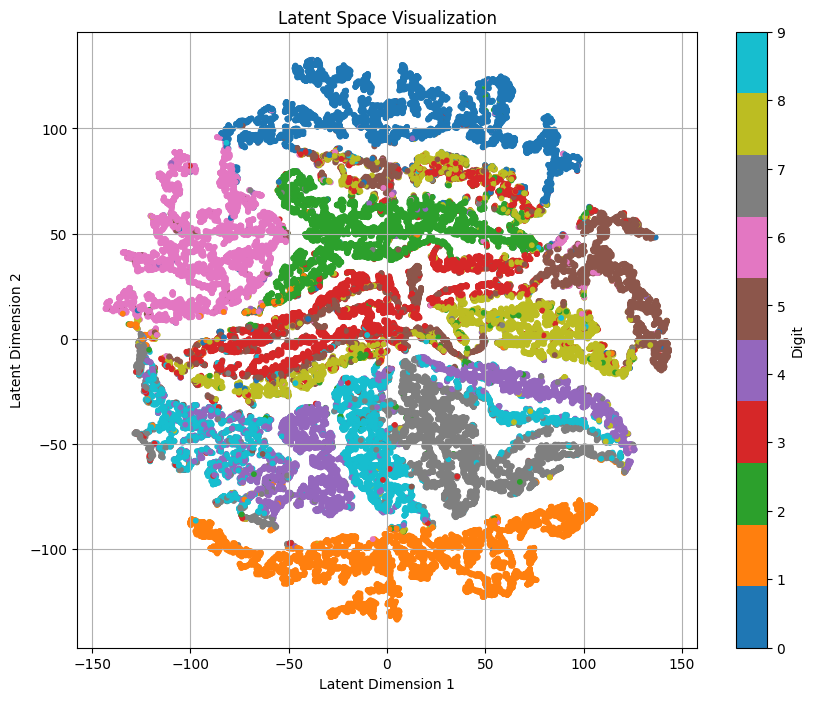

In [132]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to encode input data into the latent space
def encode_data(vae, data_loader):
    vae.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            _, mu, _ = vae(data)
            latent_vectors.append(mu)
            labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)
    return latent_vectors, labels

# Encode data into the latent space
train_latent_vectors, train_labels = encode_data(vae, train_loader)

# Perform dimensionality reduction for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(train_latent_vectors)

# Plot the latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=train_labels, cmap='tab10', s=10)
plt.colorbar(label='Digit')
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()


In [133]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    norm = torch.distributions.Normal(0, 1)
    grid_x = norm.icdf(torch.linspace(0.05, 0.95, n).to(device))
    grid_y = norm.icdf(torch.linspace(0.05, 0.95, n).to(device))
    image_width = digit_size * n
    image_height = image_width
    image = torch.zeros((image_height, image_width)).to(device)

    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = torch.tensor([[xi, yi]]).to(device)
                x_decoded = model.decoder(z)
                digit = x_decoded.view(digit_size, digit_size)
                image[i * digit_size: (i + 1) * digit_size,
                      j * digit_size: (j + 1) * digit_size] = digit.cpu()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


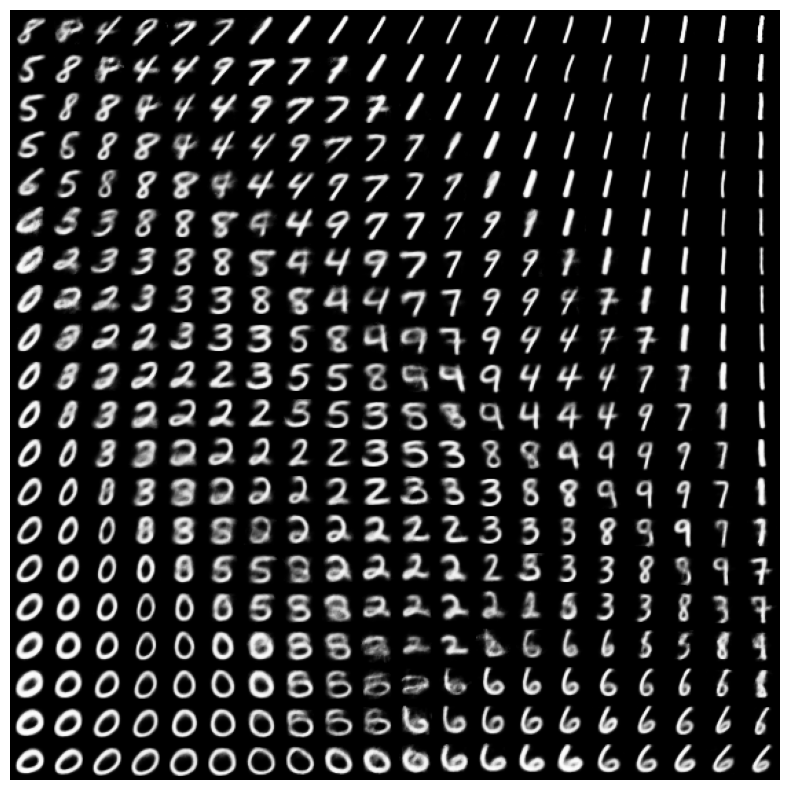

In [134]:
plot_latent_images(vae, 20)

In [135]:
torch.save(vae.state_dict(), 'vae_gaussian_1000_epoch.pth')
